In [3]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.simplefilter("ignore")

import unicodedata

import lightgbm as lgb

In [4]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    seed = 42
    n_splits = 10
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    target_bins = 10
    year_bins = 10
    num_boost_round = 10000
    stopping_rounds = 500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"

In [5]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [6]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [7]:
# ===================================================================
#  feature_engineering
# ===================================================================
# region

# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3015:2015,
        3017:2017,
        3011:2011,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df

all_data = pre_year(all_data)

# manufacturer
def convert_full_to_half(row):
    return unicodedata.normalize('NFKC', row)

all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(convert_full_to_half)

# condition

# cylinders

# fuel

# odometer

# title_status

# transmission

# drive

# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df

all_data = pre_size(all_data)

# type

# paint_color

# state

In [8]:
CFG.use_features = ['region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 
                    'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

CFG.categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 
                            'drive', 'size', 'type', 'paint_color', 'state']

In [9]:
for col in CFG.categorical_features:
    all_data[col] = all_data[col].astype("category")

In [10]:
# ===================================================================
#  train test split
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)


train.sort_values(by="id", ignore_index=True, inplace=True)
train["year_map"] = pd.cut(train["year"], bins=CFG.year_bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)

kf = MultilabelStratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(kf.split(X=train, y=train[["year_map", "price_map"]])):
    train.loc[val, "fold"] = i
    
train["fold"].value_counts()

0.0    2754
8.0    2754
6.0    2753
4.0    2753
2.0    2753
5.0    2753
9.0    2753
1.0    2753
3.0    2753
7.0    2753
Name: fold, dtype: int64

In [11]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
feature_importance_df["feature"] = CFG.use_features
print(train.shape)
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    
    # params
    lgb_param = {
        "objective": "regression",
        "metric": 'mape',
        "verbosity": -1,
        "seed" : CFG.seed,
        }
    
    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)
    
    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    num_boost_round=CFG.num_boost_round, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False)],
                    )
    
    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')
    
    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features])
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))
    
    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)
    
    # pred test
    preds.append(model.predict(test[CFG.use_features]))
    
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

(27532, 20)
fold0: 66.69956649984202
fold1: 67.92362450090357
fold2: 66.22901908410506
fold3: 63.78290094048808
fold4: 67.35737751383894
fold5: 66.24238925668622
fold6: 65.28325076668816
fold7: 65.22720428200442
fold8: 66.99508490690361
fold9: 65.44904359564659
====== CV score ======
66.11899904620047


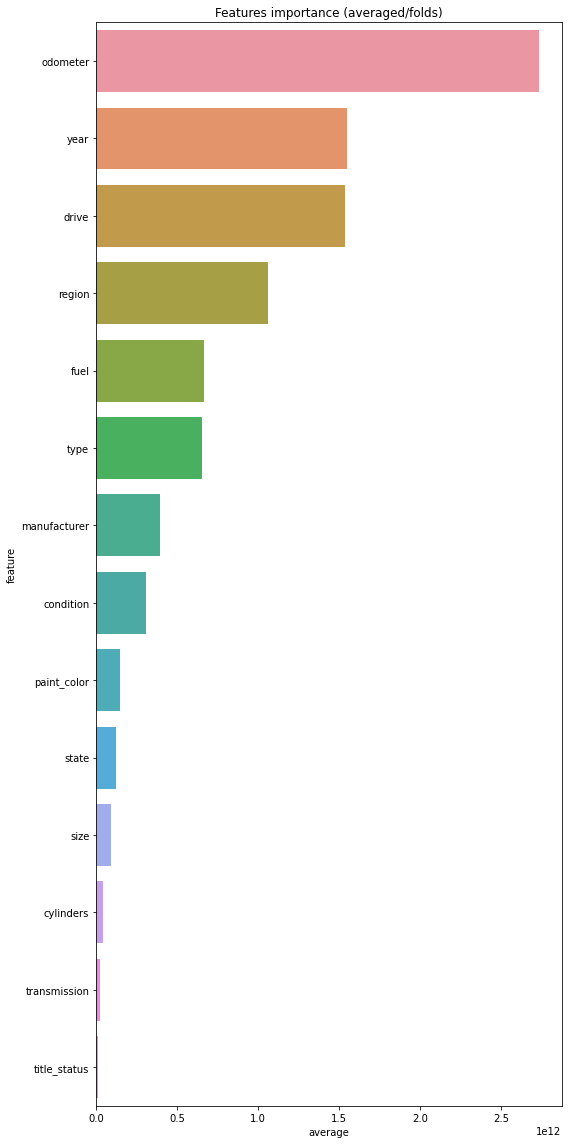

In [12]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [13]:
test["pred"] = predictions
test["pred"].head()

0    11812.584773
1     9005.077913
2     6985.415473
3    27375.217721
4     9446.593988
Name: pred, dtype: float64

In [14]:
test["pred"].min(), test["pred"].max()

(921.1264979184971, 62214.63934108465)

In [16]:
CFG.filename = "exp001"

In [17]:
test[["id", "pred"]].to_csv(CFG.save_dir+CFG.filename+".csv", index=False, header=None)

In [18]:
oof_df.to_csv(CFG.save_dir+CFG.filename+"_oof_df.csv", index=False)